In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/FER/fer2013.csv'

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,MaxPooling2D, BatchNormalization
from keras.regularizers import l2  
from tensorflow.keras import optimizers  
from keras.utils import np_utils 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

In [ ]:
cd /content/drive/MyDrive/FER

/content/drive/MyDrive/FER


In [ ]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()


Num GPUs Available:  1


True

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.shape

(35887, 3)

In [ ]:
labels=df['emotion'].unique()
print(labels)

[0 2 4 6 3 5 1]


In [ ]:
df.emotion.value_counts()


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


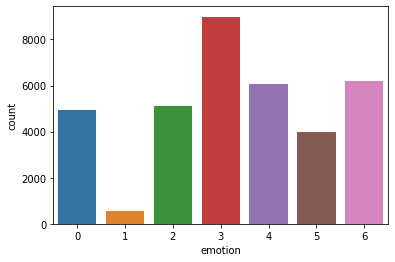

In [ ]:
sns.countplot(df.emotion)
plt.show()

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

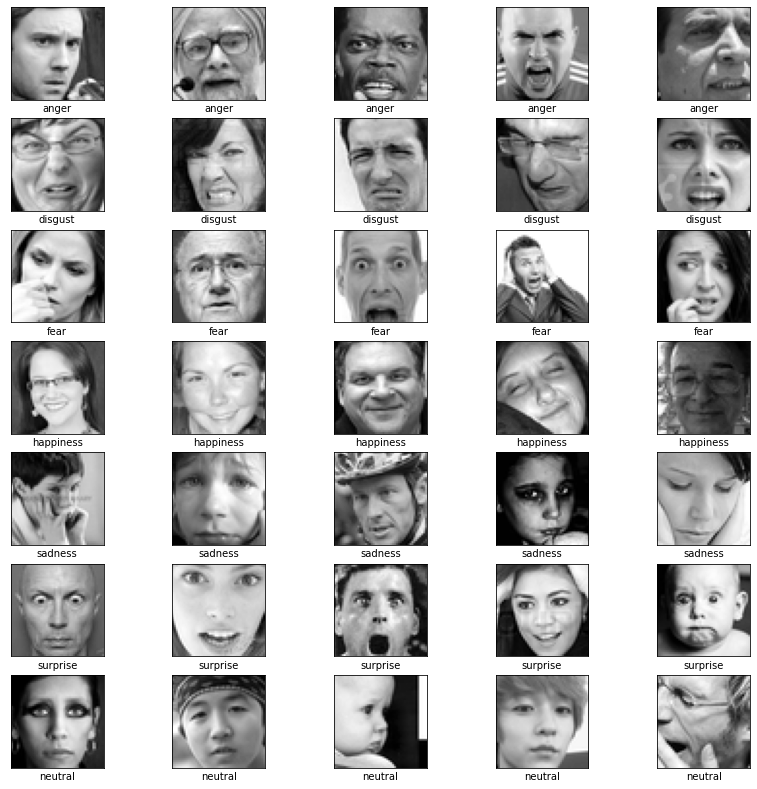

In [ ]:
plt.figure(figsize=(14,14))
for label in labels:
    for i in range(5):
        plt.subplot(7,5,i+1+(label)*5)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        px= df[df.emotion ==label].pixels.iloc[i]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        plt.imshow(px,cmap='gray')
        plt.xlabel(emotion_label_to_text[label])
plt.show()        

In [ ]:
df.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
x_train=df[df.Usage=='Training'].pixels.apply(lambda x :np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
y_train=df[df.Usage=='Training'].emotion.astype('float32')
x_test=df[(df.Usage=='PublicTest')].pixels.apply(lambda x :np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
y_test=df[(df.Usage=='PublicTest')].emotion.astype('float32')

In [ ]:

x_train=np.stack(x_train,axis=0)
x_test=np.stack(x_test,axis=0)

print(x_train.shape)
print(x_test.shape)


(28709, 48, 48, 1)
(3589, 48, 48, 1)


In [ ]:
y_train=np_utils.to_categorical(y_train,num_classes=7)
y_test =np_utils.to_categorical(y_test,num_classes=7)
x_train /=255.0
x_test /=255.0
print(y_train.shape)
print(y_train[0])

(28709, 7)
[1. 0. 0. 0. 0. 0. 0.]


In [ ]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(x_train)


In [ ]:
y_train.shape


(28709, 7)

In [ ]:
def build_net(optim):
  
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(5,5),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    net.add(
        Dense(
            64,
            activation='elu',
            name='dense_2',
            kernel_regularizer=regularizers.l2(1e-4)
            
        )
    )
    net.add(
        Dense(
            7,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)


callbacks = [
    early_stopping,
    lr_scheduler,
    checkpoint
]

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 50
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       204928    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 128)      512       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 128)       0      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


897/897 [==============================] - 61s 66ms/step - loss: 1.8996 - accuracy: 0.2483 - val_loss: 1.6644 - val_accuracy: 0.3346 - lr: 0.0010
Epoch 2/50
897/897 [==============================] - 58s 65ms/step - loss: 1.6977 - accuracy: 0.3227 - val_loss: 1.6481 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 3/50
897/897 [==============================] - 58s 65ms/step - loss: 1.5185 - accuracy: 0.4098 - val_loss: 1.3703 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 4/50
897/897 [==============================] - 58s 64ms/step - loss: 1.4147 - accuracy: 0.4581 - val_loss: 1.2540 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 5/50
897/897 [==============================] - 58s 64ms/step - loss: 1.3478 - accuracy: 0.4865 - val_loss: 1.1972 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 6/50
897/897 [==============================] - 58s 64ms/step - loss: 1.2983 - accuracy: 0.5100 - val_loss: 1.2287 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 7/50
897/897 [==============================] - 57s 64ms/step -

In [ ]:
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
   json_file.write(fer_json)  
model.save_weights("/content/drive/MyDrive/FER/fer1.h5") 


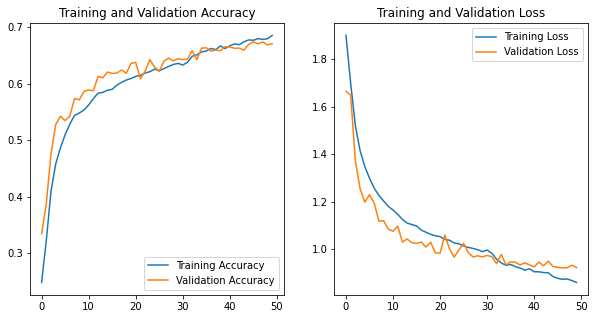

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(x_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[298   6  32  13  46  12  60]
 [ 19  23   8   0   4   0   2]
 [ 51   3 201  11 104  45  81]
 [ 20   0  20 765  13  19  58]
 [ 59   3  59  20 362  10 140]
 [ 11   0  34  13   7 340  10]
 [ 37   1  22  40  79   9 419]]


Text(69.0, 0.5, 'Truth')

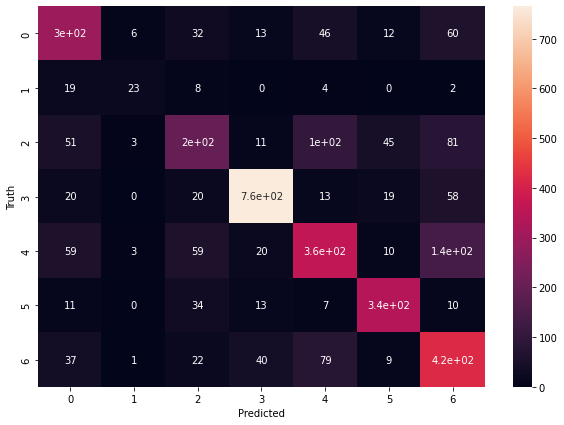

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')